In [1]:
import pandas as pd
import os
from numpy.random import default_rng

In [2]:
try:
    from google.colab import drive
    IN_COLAB=True
except:
    IN_COLAB=False

In [3]:
if IN_COLAB:
  drive.mount('/content/drive')
  base_dir ='/content/drive/MyDrive/'
  if not os.path.exists(base_dir):
    os.mkdir(base_dir)
  %cd /content/drive/MyDrive/
else:
  base_dir = os.getcwd()+'\data'
fName = input("Enter a filename (must be in standard working folder):")
file = os.path.join(base_dir, fName)
try:
  data = open(file, 'r')
  ferror = False
except FileNotFoundError:
  ferror=True
if IN_COLAB and ferror:
    from google.colab import files
    files.upload()
else:
  if ferror:
    rep=True
    while rep:
      fName1 = input("Enter complete path to the data or q (to quit):")
      if fName1 == 'q':
        exit
      else:
        try:
          data = open(fName1, 'r')
          rep=False
        except:
          print('incorrect file name')

Mounted at /content/drive
/content/drive/MyDrive
Enter a filename (must be in standard working folder):housing.txt


In [21]:
data = pd.read_csv(file, header=None, names=['longitude','latitude','housing_median_age','total_rooms',\
                                             'total_bedrooms','population','households','median_income',\
                                             'median_house_value','ocean_proximity'])

# 2. Separate features and the classifying column
# Assuming the classifying column is named 'proximity_to_sea' for illustrative purposes
# If it has a different name, replace 'proximity_to_sea' with the actual name

# Create a dataframe with only the features by dropping the classifying column
features = data.drop(columns=['ocean_proximity'])

# Create a separate data structure (Series) for the classifying column
labels = data['ocean_proximity']

# Display the first few rows of features and labels to verify
print(features.head())
print(labels.head())

print(data.isnull().sum())


   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  
0       322.0       126.0         8.3252            452600.0  
1      2401.0      1138.0         8.3014            358500.0  
2       496.0       177.0         7.2574            352100.0  
3       558.0       219.0         5.6431            341300.0  
4       565.0       259.0         3.8462            342200.0  
0    NEAR BAY
1    NEAR BAY
2    NEAR BAY
3    NEAR BAY
4    NEAR BAY
Name: ocean_proximity, dtype: object
longitude               0
latitude                0
housing_medi

In [6]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical


# 1. Check the unique labels
print("Unique labels in the dataset:", labels.unique())

# 2. Convert labels into integers using LabelEncoder
encoder = LabelEncoder()
integer_encoded_labels = encoder.fit_transform(labels)

# 3. Convert integer-encoded labels to one-hot encoded format
categorical_labels = to_categorical(integer_encoded_labels)

# Display the first few rows of integer and categorical encoded labels
print(integer_encoded_labels[:5])
print(categorical_labels[:5])


Unique labels in the dataset: ['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']
[3 3 3 3 3]
[[0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0.]]


In [8]:
from sklearn.model_selection import train_test_split

#scaler to no
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# First, split the data into a training set (80%) and a temporary set (20%)
X_train, X_temp, y_train, y_temp = train_test_split(features, categorical_labels, test_size=0.2, random_state=42)

# Now, split the temporary set into validation and testing sets, both 50% of the temporary set (i.e., 10% of the original data each)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Verify the shapes
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)
print("Testing set shape:", X_test.shape, y_test.shape)


Training set shape: (16512, 9) (16512, 5)
Validation set shape: (2064, 9) (2064, 5)
Testing set shape: (2064, 9) (2064, 5)


In [12]:
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')




In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model
model_deep = Sequential()

# Input Layer
model_deep.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))

# Hidden Layer 1
model_deep.add(Dense(128, activation='relu'))

# Hidden Layer 2
model_deep.add(Dense(128, activation='relu'))

# Hidden Layer 3
model_deep.add(Dense(128, activation='relu'))

# Classification Layer with softmax
model_deep.add(Dense(5, activation='softmax'))

model_deep.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model_deep.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 128)               1280      
                                                                 
 dense_6 (Dense)             (None, 128)               16512     
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 128)               16512     
                                                                 
 dense_9 (Dense)             (None, 5)                 645       
                                                                 
Total params: 51461 (201.02 KB)
Trainable params: 51461 (201.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [22]:
history = model_deep.fit(X_train, y_train, batch_size=256, epochs=20, validation_data=(X_val, y_val))

# After training, evaluating  the model performance:
loss, accuracy = model_deep.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")


Epoch 1/20
65/65 [==============================] - 0s 6ms/step - loss: 0.2128 - accuracy: 0.9118 - val_loss: nan - val_accuracy: 0.8886
Epoch 2/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2075 - accuracy: 0.9136 - val_loss: nan - val_accuracy: 0.8750
Epoch 3/20
65/65 [==============================] - 0s 5ms/step - loss: 0.2018 - accuracy: 0.9158 - val_loss: nan - val_accuracy: 0.8929
Epoch 4/20
65/65 [==============================] - 0s 5ms/step - loss: 0.1998 - accuracy: 0.9156 - val_loss: nan - val_accuracy: 0.8857
Epoch 5/20
65/65 [==============================] - 0s 7ms/step - loss: 0.1976 - accuracy: 0.9182 - val_loss: nan - val_accuracy: 0.8479
Epoch 6/20
65/65 [==============================] - 1s 8ms/step - loss: 0.1980 - accuracy: 0.9181 - val_loss: nan - val_accuracy: 0.8939
Epoch 7/20
65/65 [==============================] - 1s 8ms/step - loss: 0.1892 - accuracy: 0.9198 - val_loss: nan - val_accuracy: 0.8973
Epoch 8/20
65/65 [=======================

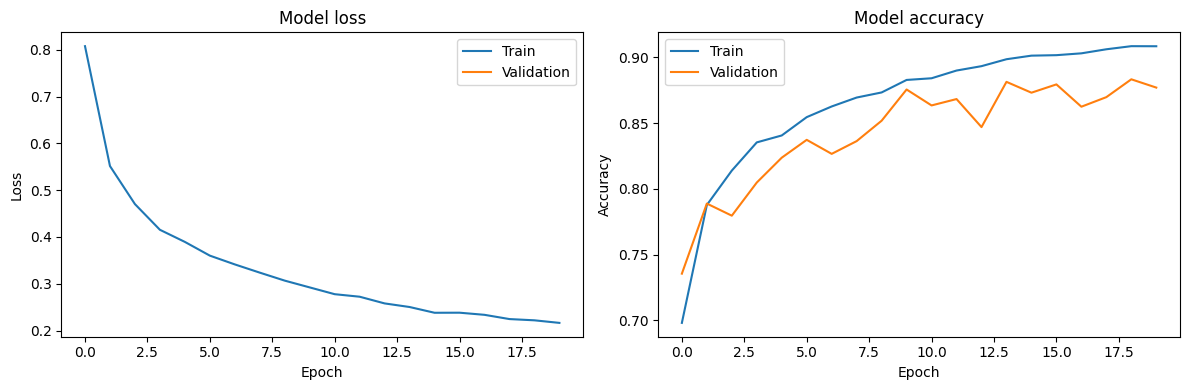

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
